# Finding cells from electron microscopy images with U-Net

This is the notebook from https://github.com/anttisaukko/unet_microscopy.


Please have a look at the README file in the github about the description of this project.

In [1]:
import os
import os.path
import sys

# Presetting the compute units for you (in case you have multiple gpus)
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0,1,2,3,4"

In [13]:
import keras
from keras.layers.core import Lambda
from keras.layers import Input, Dense, Dropout, Flatten, TimeDistributed, InputLayer, Activation, Dense
from keras.layers import Conv2D, Conv3D, MaxPooling2D, MaxPooling3D, LSTM, Reshape
from keras.layers import Concatenate, UpSampling2D, Concatenate, Add, GlobalAveragePooling1D, AveragePooling3D
from keras.layers.normalization import BatchNormalization
from keras.models import Model, Sequential, load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint

from keras.utils import multi_gpu_model
from keras import optimizers

from tensorflow.python.framework import ops
import keras.backend as K
import tensorflow as tf
import numpy as np

In [3]:
from PIL import Image
import random
import glob
from sklearn.utils import shuffle

### Make the plots look nicer below

In [4]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (18, 6)

In [5]:
print ("tensorflow version:", tf.__version__, "\nkeras version:", keras.__version__)

tensorflow version: 1.7.0 
keras version: 2.1.5


In [6]:
# Setting random seed and fixing the width and height of the images
random.seed(1917)
SAMPLE_WIDTH_HEIGHT = 464

In [7]:
# Train and test split
train_files = glob.glob("./HSV_ALL/inp/[1-8]_image*.tiff")
test_files = glob.glob("./HSV_ALL/inp/9_image*.tiff")

len(train_files), len(test_files)

(3426, 614)

In [8]:
# Helper method to produce images, produces 4 outputs
# input image, output image, input numpy array, output numpy array

def produceImages(sampleFile, sampledir="./HSV_ALL/", rotate=True):
    # Make both dimensions same
    force_dimension = SAMPLE_WIDTH_HEIGHT 
    
    basename = os.path.basename(sampleFile)
    
    original = '%s/%s/%s'% (sampledir, 'inp', basename)
    labeled  =  '%s/%s/%s' % (sampledir, 'out', basename)
    
    if (os.path.isfile(original) == False | os.path.isfile(labeled) == False):
        print("The following file does not exist", basename, original, labeled)

    rotation = 0
    
    if (rotate):
        rotation = random.randint(0, 359)

    i1 = Image.open(original).rotate(rotation)
    o1 = Image.open(labeled).rotate(rotation)
    
    i1np = np.asarray(i1)[0:force_dimension, 0:force_dimension]
    o1np = np.asarray(o1)[0:force_dimension, 0:force_dimension]
    
    i1np = i1np.astype('float32') / 255.0
    o1np = o1np.astype('float32') / 255.0

    return i1, o1, i1np, o1np
    

In [9]:
a, b, c, d = produceImages("3_image_0229.tiff")
print("Sample shape: ", c.shape)

Sample shape:  (464, 464)


In [10]:
# The generator that keeps on producing images

def img_generator(filelist, rotate=True, debug=False, reshape_adjust=False, batch_size=8):
    while True:
        data_len = len(filelist)
        
        # Go through all of data in batch_size's
        for i in range(0, len(filelist), batch_size):                
            # Stop when there is no more data
            end_pos = min(data_len, i+batch_size)
            xarr = []
            yarr = []
            
            # Compose the output from the generator
            for items in range(i, end_pos, 1):
                if (debug):
                    print(filelist[items])
                _, _, xdata, ydata = produceImages(filelist[items], rotate=rotate)
                
                xdata = xdata.reshape(SAMPLE_WIDTH_HEIGHT, SAMPLE_WIDTH_HEIGHT, 1)
                ydata = ydata.reshape(SAMPLE_WIDTH_HEIGHT, SAMPLE_WIDTH_HEIGHT, 1)
                    
                xarr.append(xdata)
                yarr.append(ydata)

            yield (np.array(xarr), np.array(yarr))

In [11]:
gen = img_generator(train_files, rotate=False, debug=False, reshape_adjust=False, batch_size=4)
mx, my = next(gen)

### The original image, the ground truth image and the original image with groun truth overlayed on top

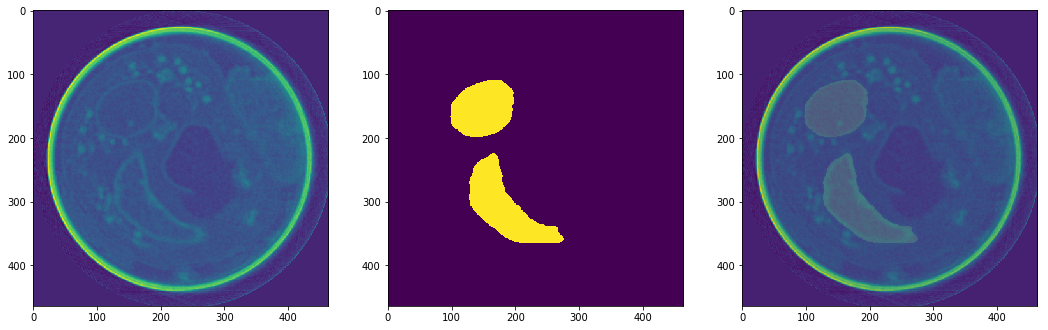

In [37]:
rows = 1
cols = 3

f, ax = plt.subplots(rows, cols)

ax[0].imshow(mx[1].reshape(SAMPLE_WIDTH_HEIGHT, SAMPLE_WIDTH_HEIGHT))
ax[1].imshow(my[1].reshape(SAMPLE_WIDTH_HEIGHT, SAMPLE_WIDTH_HEIGHT))
ax[2].imshow(mx[1].reshape(SAMPLE_WIDTH_HEIGHT, SAMPLE_WIDTH_HEIGHT))
ax[2].imshow(my[1].reshape(SAMPLE_WIDTH_HEIGHT, SAMPLE_WIDTH_HEIGHT), alpha=0.1)

## U-Net architecture

In [88]:
inputs = Input((SAMPLE_WIDTH_HEIGHT, SAMPLE_WIDTH_HEIGHT, 1))
act = "relu"
padd = "same"
init = "he_normal"

conv1 = Conv2D(64, 3, activation = act, padding = padd, kernel_initializer = init)(inputs)
conv1 = Conv2D(64, 3, activation = act, padding = padd, kernel_initializer = init)(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

conv2 = Conv2D(128, 3, activation = act, padding = padd, kernel_initializer = init)(pool1)
conv2 = Conv2D(128, 3, activation = act, padding = padd, kernel_initializer = init)(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

conv3 = Conv2D(256, 3, activation = act, padding = padd, kernel_initializer = init)(pool2)
conv3 = Conv2D(256, 3, activation = act, padding = padd, kernel_initializer = init)(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

conv4 = Conv2D(512, 3, activation = act, padding = padd, kernel_initializer = init)(pool3)
conv4 = Conv2D(512, 3, activation = act, padding = padd, kernel_initializer = init)(conv4)
drop4 = Dropout(0.5)(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

conv5 = Conv2D(1024, 3, activation = act, padding = padd, kernel_initializer = init)(pool4)
conv5 = Conv2D(1024, 3, activation = act, padding = padd, kernel_initializer = init)(conv5)
drop5 = Dropout(0.5)(conv5)

up6 = UpSampling2D(size = (2, 2))(drop5)
up6 = Conv2D(512, 2, activation = act, padding = padd, kernel_initializer = init)(up6)

merge6 = Concatenate()([drop4, up6])
conv6 = Conv2D(512, 3, activation = act, padding = padd, kernel_initializer = init)(merge6)
conv6 = Conv2D(512, 3, activation = act, padding = padd, kernel_initializer = init)(conv6)

up7 = UpSampling2D(size = (2, 2))(conv6)
up7 = Conv2D(256, 2, activation = act, padding = padd, kernel_initializer = init)(up7)

merge7 = Concatenate()([conv3, up7])
conv7 = Conv2D(256, 3, activation = act, padding = padd, kernel_initializer = init)(merge7)
conv7 = Conv2D(256, 3, activation = act, padding = padd, kernel_initializer = init)(conv7)

up8 = UpSampling2D(size = (2, 2))(conv7)
up8 = Conv2D(128, 2, activation = act, padding = padd, kernel_initializer = init)(up8)

merge8 = Concatenate()([conv2, up8])
conv8 = Conv2D(128, 3, activation = act, padding = padd, kernel_initializer = init)(merge8)
conv8 = Conv2D(128, 3, activation = act, padding = padd, kernel_initializer = init)(conv8)

up9 = UpSampling2D(size = (2,2))(conv8)
up9 = Conv2D(64, 2, activation = act, padding = padd, kernel_initializer = init)(up9)

merge9 = Concatenate()([conv1, up9])
conv9 = Conv2D(64, 3, activation = act, padding = padd, kernel_initializer = init)(merge9)
conv9 = Conv2D(64, 3, activation = act, padding = padd, kernel_initializer = init)(conv9)
conv9 = Conv2D(2, 3, activation = act, padding = padd, kernel_initializer = init)(conv9)
output = Conv2D(1, 1, activation = 'sigmoid')(conv9)

model = Model(inputs = inputs, outputs = output)
model.compile(optimizer = optimizers.Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])

In [89]:
# For multi-gpu configuration:
# Keep the model with CPU so the system wont get crazy when merging the  
# backpropragated weights
with tf.device('/cpu:0'):
    model = Model(inputs = inputs, outputs = output)

# Change the gpus=NN to the number of gpus you have
parallel_model = multi_gpu_model(model, gpus=2)
parallel_model.compile(optimizer = optimizers.Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])

In [92]:
# Two callbacks for 1) stopping if no progress is made in 10 epochs
# 2) checkpointing the current progress when the validation loss reduces

early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')
checkpoint = ModelCheckpoint("./model/cell_u_net_v3_nv3.h5", 
                             monitor='val_loss', verbose=0, save_best_only=True, 
                             save_weights_only=False, mode='auto', period=1)

In [93]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 464, 464, 1)  0                                            
__________________________________________________________________________________________________
conv2d_73 (Conv2D)              (None, 464, 464, 64) 640         input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_74 (Conv2D)              (None, 464, 464, 64) 36928       conv2d_73[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_13 (MaxPooling2D) (None, 232, 232, 64) 0           conv2d_74[0][0]                  
__________________________________________________________________________________________________
conv2d_75 

In [94]:
gen = img_generator(train_files, debug=True, reshape_adjust=False, batch_size=4)
mx, my = next(gen)

./HSV_ALL/inp/4_image_0181.tiff
./HSV_ALL/inp/6_image_0036.tiff
./HSV_ALL/inp/1_image_0142.tiff
./HSV_ALL/inp/8_image_0189.tiff


In [22]:
# Current batch size
BATCH_SIZE = 4

early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')
checkpoint = ModelCheckpoint("./model/cell_u_net_v3_testfiles_1_0.h5", 
                             monitor='val_loss', verbose=0, save_best_only=True, 
                             save_weights_only=False, mode='auto', period=1)

history = model.fit_generator(img_generator(train_files, reshape_adjust=False, batch_size=BATCH_SIZE), 
                    validation_data=img_generator(test_files, reshape_adjust=False, batch_size=BATCH_SIZE),
                    steps_per_epoch=len(train_files)/BATCH_SIZE,
                    callbacks=[early_stopping, checkpoint],
                    validation_steps=len(test_files)/BATCH_SIZE,
                    verbose=2,
                    initial_epoch=0,
                    epochs=10,
                    shuffle=True,
                    use_multiprocessing=True)

Epoch 1/10
 - 696s - loss: 0.2169 - acc: 0.8772 - val_loss: 0.1516 - val_acc: 0.9521
Epoch 2/10
 - 687s - loss: 0.1851 - acc: 0.9029 - val_loss: 0.1557 - val_acc: 0.9347
Epoch 3/10
 - 687s - loss: 0.1726 - acc: 0.9119 - val_loss: 0.1170 - val_acc: 0.9552
Epoch 4/10
 - 688s - loss: 0.1415 - acc: 0.9307 - val_loss: 0.0939 - val_acc: 0.9601
Epoch 5/10
 - 687s - loss: 0.1266 - acc: 0.9406 - val_loss: 0.0914 - val_acc: 0.9623
Epoch 6/10
 - 687s - loss: 0.0971 - acc: 0.9574 - val_loss: 0.0779 - val_acc: 0.9663
Epoch 7/10
 - 687s - loss: 0.0735 - acc: 0.9695 - val_loss: 0.0645 - val_acc: 0.9722
Epoch 8/10
 - 687s - loss: 0.0597 - acc: 0.9760 - val_loss: 0.0728 - val_acc: 0.9686
Epoch 9/10
 - 686s - loss: 0.0504 - acc: 0.9798 - val_loss: 0.0627 - val_acc: 0.9743
Epoch 10/10
 - 686s - loss: 0.0469 - acc: 0.9813 - val_loss: 0.0611 - val_acc: 0.9749


In [24]:
# run for additional 10 epochs
history2 = model.fit_generator(img_generator(train_files, reshape_adjust=False, batch_size=BATCH_SIZE), 
                    validation_data=img_generator(test_files, reshape_adjust=False, batch_size=BATCH_SIZE),
                    steps_per_epoch=len(train_files)/BATCH_SIZE,
                    callbacks=[early_stopping, checkpoint],
                    validation_steps=len(test_files)/BATCH_SIZE,
                    verbose=2,
                    initial_epoch=10,
                    epochs=20,
                    shuffle=True,
                    use_multiprocessing=True)

Epoch 11/20
 - 668s - loss: 0.0405 - acc: 0.9838 - val_loss: 0.0620 - val_acc: 0.9737
Epoch 12/20
 - 670s - loss: 0.0374 - acc: 0.9851 - val_loss: 0.0579 - val_acc: 0.9772
Epoch 13/20
 - 670s - loss: 0.0380 - acc: 0.9849 - val_loss: 0.0637 - val_acc: 0.9750
Epoch 14/20
 - 671s - loss: 0.0326 - acc: 0.9869 - val_loss: 0.0673 - val_acc: 0.9742
Epoch 15/20
 - 671s - loss: 0.0312 - acc: 0.9873 - val_loss: 0.0559 - val_acc: 0.9790
Epoch 16/20
 - 671s - loss: 0.0302 - acc: 0.9879 - val_loss: 0.0602 - val_acc: 0.9772
Epoch 17/20
 - 671s - loss: 0.0334 - acc: 0.9867 - val_loss: 0.0608 - val_acc: 0.9758
Epoch 18/20
 - 670s - loss: 0.0256 - acc: 0.9894 - val_loss: 0.0556 - val_acc: 0.9789
Epoch 19/20
 - 671s - loss: 0.0256 - acc: 0.9894 - val_loss: 0.0594 - val_acc: 0.9779
Epoch 20/20
 - 670s - loss: 0.0239 - acc: 0.9900 - val_loss: 0.0559 - val_acc: 0.9794


In [25]:
# Save the latest model
model.save("model/final_unet_first_20_epocs.h5")

In [96]:
# Load the best saved model
model = load_model("model/cell_u_net_v3_testfiles_1_0.h5")

In [29]:
testGenerator = img_generator(test_files, reshape_adjust=False, batch_size=1)

In [30]:
def correctlyPredictedPixels(groundTruth, prediction, threshold = 0.5):
    prediction[prediction > threshold] = 1.0
    prediction[prediction <= threshold] = 0.0
    
    correct = np.sum(prediction == groundTruth) / groundTruth.flatten().shape[0]
    return correct
    

### Original image, ground truth image, prediction with probabilities, ground truth with predictions overlayed

Pixels correctly classified:  0.9928888599881094


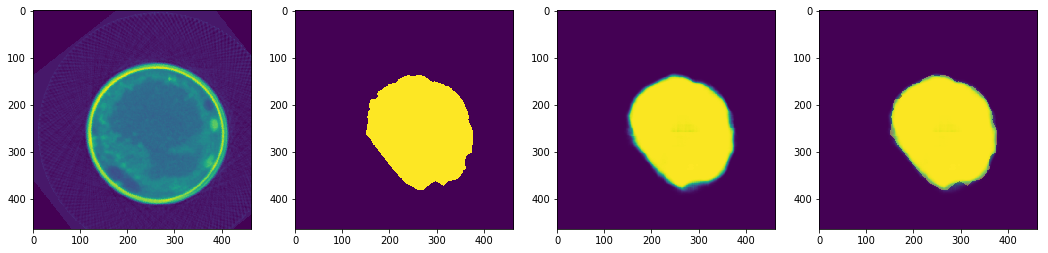

In [103]:
tomo_image, ground_truth = next(testGenerator)

rows = 1
cols = 4

f, ax = plt.subplots(rows, cols)

phat       = model.predict(tomo_image)
image      = Image.fromarray((tomo_image.reshape(SAMPLE_WIDTH_HEIGHT, SAMPLE_WIDTH_HEIGHT)*255).astype("uint8"))
gt_image   = Image.fromarray((ground_truth.reshape(SAMPLE_WIDTH_HEIGHT,SAMPLE_WIDTH_HEIGHT)*255).astype("uint8"))
prediction = Image.fromarray((phat.reshape(SAMPLE_WIDTH_HEIGHT, SAMPLE_WIDTH_HEIGHT)*255).astype("uint8"))


ax[0].imshow(image)
ax[1].imshow(gt_image)
ax[2].imshow(prediction)
ax[3].imshow(gt_image)
ax[3].imshow(prediction, alpha=0.6)

print("Pixels correctly classified: ", correctlyPredictedPixels(ground_truth, phat))

In [99]:
tstgen = img_generator(test_files, reshape_adjust=False, batch_size=1)

image_predictions = []

for i in test_files:
    tomo_image, ground_truth = next(testGenerator)
    phat = model.predict(tomo_image)
    image_predictions.append(correctlyPredictedPixels(ground_truth, phat))

### Testing performance -- or per pixel accuracy

In [79]:
np_img_pred = np.array(image_predictions)
np_img_pred.sort()
print("Worst prediction accuracy:", round(np_img_pred.min(), 5), "Best:", round(np_img_pred.max(), 5))
print("Median accuracy:", round(np_img_pred[int(len(np_img_pred)/2)], 5))

Worst prediction accuracy: 0.98126 Best: 0.99986
Median accuracy: 0.99304
